In [ ]:
!pip install brainiak

In [19]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from brainiak.funcalign.srm import SRM
from brainiak.isc import isc

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
roi = 'A1'
filepath = 'drive/MyDrive/fMRI_music_data/%s_by_subject_sorted_conds/'%roi
subjects = ['03','15','20','23']
n_sub = len(subjects)

In [4]:
# load data from one subject for a quick sanity check
this_subj = subjects[0]
test = np.load(filepath+'%s_sub-1%s.npy'%(roi,this_subj))
print(test.shape)

(516, 1776)


There are 516 voxels in A1. There are 1776 total time points: 148 TRs per run * 12 runs.

In [5]:
# load in the data from all subjects
data = []
for subj in subjects: 
  data.append(np.load(filepath+'%s_sub-1%s.npy'%(roi,this_subj)))

# recast the list into an array and check the shape
data = np.asarray(data)
print(data.shape)

(4, 516, 1776)


Reshape the data so that it's subjects x voxels x TRs x conds x runs. This gives flexibility to select training and testing data for SRM later.

In [6]:
n_voxels = data.shape[1]
n_TRs = 148
n_conds = 4
n_runs = 3

orig_data = np.copy(data)
orig_data = np.reshape(orig_data,(n_sub,n_voxels,n_TRs,n_conds,n_runs),order='F')
print(orig_data.shape)

(4, 516, 148, 4, 3)


As long as this array acts like the toy example (see earlier version and `ryc_toy_reshaping.ipynb`), then `order = 'F'` should keep the individual runs intact during the reshaping.

Before looking at any runs or conditions in particular, first we'll split the data into two folds and perform a k sweep. The following code is adapted in part from `ryc_TRxTR-SRM_090721.ipynb` which was adapted from the BrainIAK tutorial on SRM (number 11). The outcome measure will be feature-wise ISC, averaged over features and subjects.

In [11]:
# split the data into two halves
data_firsthalf = data[:,:,:data.shape[2]//2]
data_secondhalf = data[:,:,data.shape[2]//2:]
print(data_firsthalf.shape)
print(data_secondhalf.shape)

(4, 516, 888)
(4, 516, 888)


(The training and testing data for SRM don't necessarily have to be the same size, but they are in this case.)

In [16]:
# set which k-values to use
k_low = np.arange(10).tolist()
k_mid = np.arange(10,100,10).tolist()
k_high = np.arange(100,400,50).tolist()
k = k_low + k_mid + k_high
print(k)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350]


In [23]:
# first fold
train_data = data_firsthalf
test_data = data_secondhalf

# normalize data in time for each subject
for s in range(len(subjects)):
  train_data[s] = stats.zscore(train_data[s],axis=1)
  test_data[s] = stats.zscore(test_data[s],axis=1)

print(train_data.shape)

(4, 516, 888)


In [26]:
k = [1,2]

n_iter = 20

isc_means = []

for features in k:

  # create the SRM object
  srm = SRM(n_iter=n_iter, features=features)

  # fit the SRM data
  srm.fit(train_data)
  print('SRM with %d features has been fit'%features)

  # transform the test data
  shared_test = srm.transform(test_data)

  # reshape data for ISC
  # data has to be TRs x voxels/features x subjects
  shared_test = np.asarray(shared_test)
  shared_test = np.transpose(shared_test,axes=[2,1,0])

  # compute ISC
  shared_test_isc = isc(shared_test)

  # average over subjects
  isc_by_feat = np.average(shared_test_isc,axis=0)
  print(isc_by_feat)

  # compute the mean ISC value
  isc_means.append(np.average(isc_by_feat))

SRM with 1 features has been fit
[1.]
SRM with 2 features has been fit
[1. 1.]


In [25]:
print(isc_means)

[1.0, 1.0]


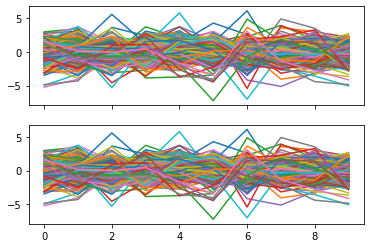

In [35]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(train_data[0,:10,:])
ax[1].plot(train_data[1,:10,:]);